<a href="https://colab.research.google.com/github/sethkipsangmutuba/OOP---Telecommunication-Information-Engineering-Python/blob/main/a1_OOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Note1

# Object-Oriented Design
##Seth Kipsang

## Introduction
Introduction to object-oriented thinking in telecommunication and information systems

## Objects and Classes
Objects and classes as models of network entities

## Attributes and Behaviours
Defining attributes and behaviours for telecom components  
Using data to describe system state  
Behaviours as actions performed by network or protocol elements

## Encapsulation
Hiding internal mechanics and defining clear service interfaces

## Composition
Composition for building complex network functions from simpler parts

## Inheritance
Inheritance for structuring families of related telecom components  
Using inheritance to create higher-level abstractions in system design  
Multiple inheritance where components require mixed capabilities

## Case Study
Case study based on a telecom subsystem

## Exercises
Exercises

## Summary
Summary


#a) Object-Oriented Design

In software development, design, analysis, and programming often overlap rather than occurring sequentially. In telecommunications and information systems, this iterative approach is essential, as network protocols, billing systems, and distributed services require continuous refinement.

##Key Definitions

**Object:** A software entity representing a real-world component or concept. In telecom systems, objects can be network nodes, packets, sessions, users, or protocol handlers. An object encapsulates data (attributes) describing its state and behaviors (methods) defining its actions.

**Class:** A blueprint or template that defines the structure (attributes) and behaviors (methods) of objects. For example, a NetworkNode class may define fields such as nodeID, status, and methods like sendPacket() or receivePacket().

**Attribute:** A property or piece of data associated with an object, representing its state. Example: bandwidth of a network link, balance of a user account.

**Behavior (Method):** A function or operation that an object can perform, often interacting with other objects. Example: routePacket() in a Router object.

**Object-Oriented Analysis (OOA):** The process of identifying objects and their interactions in a system. Focuses on what the system must do, producing requirements like “a user can initiate a transaction” or “a router forwards packets based on routing rules.”

**Object-Oriented Design (OOD):** The process of converting requirements into a blueprint of objects, classes, and their interactions. Focuses on how the system should be structured, e.g., defining classes Transaction, BillingEngine, and MessageQueue with their respective behaviors.

**Object-Oriented Programming (OOP):** The implementation of the design in code, turning class definitions and interactions into working software. Iterative development is common in telecom applications to handle network complexity, concurrency, and system scaling.

## Concepts in Telecommunications Context

Objects model network entities and services: nodes, links, packets, sessions, billing components.

Attributes capture state, behaviors define operations: e.g., sendPacket() changes the state of a packet object and updates a message queue.

Iterative development aligns with real telecom system deployment, where features, network failures, and scaling requirements evolve continuously.

Interfaces define clear points of interaction between components, ensuring modularity, maintainability, and reliability in distributed systems.


###Example1 : OOD Telecom Simulation

This Python simulation models a simple telecom network using object-oriented design. Hosts generate packets to send to other hosts via a router with defined service rates, bandwidth, and latency. Packets are queued, forwarded, and tracked for delivery, while a billing engine computes cumulative charges per host. The simulator logs events, queue lengths, deliveries, and revenue, producing a summary DataFrame, annotated plots of packet deliveries, queues, and billing over time, and CSV outputs. It demonstrates encapsulation, composition, inheritance, and polymorphism in a dynamic, reproducible network environment.


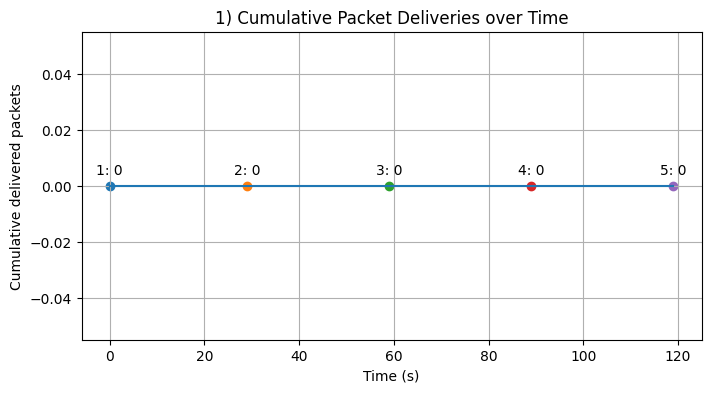

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from dataclasses import dataclass
import time

np.random.seed(20251118)  # reproducible

# --- Domain classes ---

@dataclass
class Packet:
    pkt_id: int
    src: str
    dst: str
    size_bytes: int
    creation_time: float
    payload_type: str = "data"
    delivered: bool = False
    delivered_time: float = None

    def size_mb(self):
        return self.size_bytes / (1024*1024)

class MessageQueue:
    def __init__(self, capacity_packets=np.inf):
        self.capacity = capacity_packets
        self._queue = deque()
        self.total_dropped = 0

    def push(self, pkt: Packet, now: float):
        if len(self._queue) < self.capacity:
            self._queue.append(pkt)
            return True
        else:
            self.total_dropped += 1
            return False

    def pop(self):
        if self._queue:
            return self._queue.popleft()
        return None

    def __len__(self):
        return len(self._queue)

class NetworkNode:
    def __init__(self, node_id):
        self.node_id = node_id
        self.queue = MessageQueue(capacity_packets=10000)
        self.sent = 0
        self.received = 0

    def receive(self, pkt: Packet, now: float):
        accepted = self.queue.push(pkt, now)
        return accepted

    def process_one(self, now: float):
        pkt = self.queue.pop()
        return pkt

class Router(NetworkNode):
    def __init__(self, node_id, service_rate_pps=1000):
        super().__init__(node_id)
        self.service_rate = service_rate_pps
        self.forwarding_table = {}
        self.out_links = {}  # neighbor_id -> dict(node, bandwidth_bps, latency_s)
        self.time_accumulator = 0.0

    def add_link(self, neighbor_node, bandwidth_bps=1e7, latency_s=0.001):
        self.out_links[neighbor_node.node_id] = {"node": neighbor_node, "bandwidth_bps": bandwidth_bps, "latency_s": latency_s}

    def set_forwarding(self, dst, next_hop):
        self.forwarding_table[dst] = next_hop

    def process_one(self, now: float):
        # use service_rate to regulate processing: allow 1 packet per (1/service_rate) seconds in accumulator steps
        self.time_accumulator += 1.0 / max(self.service_rate, 1e-9)
        if self.time_accumulator >= 1.0:
            pkt = self.queue.pop()
            if pkt is None:
                self.time_accumulator = 0.0
                return None
            next_hop_id = self.forwarding_table.get(pkt.dst, None)
            if next_hop_id is None:
                return None
            link = self.out_links.get(next_hop_id, None)
            if link is None:
                return None
            ser_delay = pkt.size_bytes * 8.0 / link["bandwidth_bps"]
            arrival_time = now + link["latency_s"] + ser_delay
            self.time_accumulator = 0.0
            return ("forward", link["node"], pkt, arrival_time)
        return None

class Host(NetworkNode):
    def __init__(self, node_id, gen_rate_pps=10, avg_pkt_size=1500):
        super().__init__(node_id)
        self.gen_rate = gen_rate_pps
        self.avg_pkt_size = avg_pkt_size
        self.sent_packets = []
        self.received_packets = []
        self._gen_acc = 0.0

    def generate(self, now, dst, pkt_id_counter):
        p = self.gen_rate * 1.0  # dt=1 s in coarse sim
        k = np.random.poisson(p)
        new_pkts = []
        for _ in range(k):
            size = max(64, int(np.random.exponential(self.avg_pkt_size)))
            pkt = Packet(pkt_id=pkt_id_counter(), src=self.node_id, dst=dst, size_bytes=size, creation_time=now)
            new_pkts.append(pkt)
            self.sent += 1
            self.sent_packets.append(pkt)
        return new_pkts

class BillingEngine:
    def __init__(self, rate_per_mb=0.01):
        self.rate_per_mb = rate_per_mb
        self.revenue_by_host = defaultdict(float)
        self.records = []

    def bill_packet(self, pkt: Packet, now: float):
        charge = pkt.size_mb() * self.rate_per_mb
        self.revenue_by_host[pkt.src] += charge
        self.records.append({"time": now, "src": pkt.src, "dst": pkt.dst, "pkt_id": pkt.pkt_id, "charge": charge, "size_mb": pkt.size_mb()})

# --- Simulator core ---

class SimpleNetworkSimulator:
    def __init__(self, duration_s=100, dt=1.0):
        self.now = 0.0
        self.duration = duration_s
        self.dt = dt
        self.nodes = {}
        self.events = []
        self.pkt_counter = 0
        self.billing = BillingEngine(rate_per_mb=0.05)
        self.trace = []

    def pkt_id_counter(self):
        self.pkt_counter += 1
        return self.pkt_counter

    def add_node(self, node):
        self.nodes[node.node_id] = node

    def schedule_arrival(self, arrival_time, node, pkt):
        self.events.append((arrival_time, node, pkt))

    def run(self):
        self.events.sort(key=lambda x: x[0])
        for t in range(int(self.duration)):
            self.now = t * self.dt
            # For this demo assume nodes H1, H2, router R1 exist
            h1 = self.nodes["H1"]
            h2 = self.nodes["H2"]
            r1 = self.nodes["R1"]
            # packet generation
            new_from_h1 = h1.generate(self.now, dst="H2", pkt_id_counter=self.pkt_id_counter)
            new_from_h2 = h2.generate(self.now, dst="H1", pkt_id_counter=self.pkt_id_counter)
            for pkt in new_from_h1:
                ser_delay = pkt.size_bytes * 8.0 / r1.out_links["H1"]["bandwidth_bps"]
                arrival = self.now + r1.out_links["H1"]["latency_s"] + ser_delay
                self.schedule_arrival(arrival, r1, pkt)
            for pkt in new_from_h2:
                ser_delay = pkt.size_bytes * 8.0 / r1.out_links["H2"]["bandwidth_bps"]
                arrival = self.now + r1.out_links["H2"]["latency_s"] + ser_delay
                self.schedule_arrival(arrival, r1, pkt)

            # process arrivals up to now+dt
            self.events.sort(key=lambda x: x[0])
            while self.events and self.events[0][0] <= self.now + self.dt:
                arrival_time, node, pkt = self.events.pop(0)
                node.receive(pkt, arrival_time)
                self.trace.append({"time": arrival_time, "event": "arrive", "node": node.node_id, "pkt": pkt.pkt_id, "queue_len": len(node.queue)})

            # routers process
            for node in self.nodes.values():
                if isinstance(node, Router):
                    max_attempts = int(node.service_rate * self.dt)
                    for _ in range(max_attempts):
                        res = node.process_one(self.now)
                        if res is None:
                            break
                        if res[0] == "forward":
                            _, neighbor, pkt, arrival_time = res
                            self.schedule_arrival(arrival_time, neighbor, pkt)
                            self.trace.append({"time": self.now, "event": "forward", "from": node.node_id, "to": neighbor.node_id, "pkt": pkt.pkt_id, "queue_len": len(node.queue)})
                elif isinstance(node, Host):
                    pkt = node.queue.pop()
                    if pkt is not None:
                        pkt.delivered = True
                        pkt.delivered_time = self.now
                        node.received += 1
                        node.received_packets.append(pkt)
                        self.billing.bill_packet(pkt, self.now)
                        self.trace.append({"time": self.now, "event": "deliver", "node": node.node_id, "pkt": pkt.pkt_id, "queue_len": len(node.queue)})

            # snapshot
            queue_lengths = {nid: len(n.queue) for nid, n in self.nodes.items()}
            revenue = dict(self.billing.revenue_by_host)
            self.trace.append({"time": self.now, "event": "snapshot", "queues": queue_lengths, "revenue": revenue})

        self.trace_df = pd.DataFrame(self.trace)
        return self.trace_df

# --- Build topology and run ---

sim = SimpleNetworkSimulator(duration_s=120, dt=1.0)
H1 = Host("H1", gen_rate_pps=5, avg_pkt_size=1200)
H2 = Host("H2", gen_rate_pps=3, avg_pkt_size=1000)
R1 = Router("R1", service_rate_pps=200)

R1.add_link(H1, bandwidth_bps=5e6, latency_s=0.005)
R1.add_link(H2, bandwidth_bps=5e6, latency_s=0.005)
R1.set_forwarding("H1", "H1")
R1.set_forwarding("H2", "H2")

sim.add_node(H1); sim.add_node(H2); sim.add_node(R1)

trace_df = sim.run()

# --- Sanity checks ---
billing_records = pd.DataFrame(sim.billing.records)
delivered_count = len(H1.received_packets) + len(H2.received_packets)
if len(billing_records) != delivered_count:
    raise RuntimeError(f"Billing records ({len(billing_records)}) != delivered ({delivered_count})")

# --- Build summary DataFrame (robust extraction of 'queues') ---
snapshots = trace_df[trace_df['event'] == 'snapshot'].reset_index(drop=True)

# Defensive: ensure we have a 'queues' series of dict-like objects
if 'queues' not in snapshots.columns:
    # find any column that contains dict-like entries and try to extract 'queues' from it
    dict_like_cols = [c for c in snapshots.columns if snapshots[c].apply(lambda x: isinstance(x, dict)).any()]
    if len(dict_like_cols) == 0:
        # as a last resort, create empty queue dicts (shouldn't happen for your sim)
        snapshots['queues'] = [{} for _ in range(len(snapshots))]
    else:
        # pick the first dict-like column and extract 'queues' if present, otherwise default {}
        container_col = dict_like_cols[0]
        snapshots['queues'] = snapshots[container_col].apply(lambda d: d.get('queues', {}) if isinstance(d, dict) else {})

# Now snapshots['queues'] is a column of dict-like or empty dicts
def safe_get_q(qobj, key):
    return qobj.get(key, 0) if isinstance(qobj, dict) else 0

times = snapshots['time'].astype(float).values
q_H1 = [safe_get_q(q, 'H1') for q in snapshots['queues']]
q_H2 = [safe_get_q(q, 'H2') for q in snapshots['queues']]
q_R1 = [safe_get_q(q, 'R1') for q in snapshots['queues']]

# Build delivered counts dictionary keyed by time (float) for robust lookup
delivered_events = trace_df[trace_df['event'] == 'deliver']
delivered_count_by_time = delivered_events.groupby('time').size().to_dict()
delivered_cum = np.cumsum([delivered_count_by_time.get(t, 0) for t in times])

# Build billing cumulative series keyed by time
if len(billing_records) > 0:
    billing_sum_by_time = billing_records.groupby('time')['charge'].sum().to_dict()
    billing_cum = np.cumsum([billing_sum_by_time.get(t, 0.0) for t in times])
else:
    billing_cum = np.zeros_like(times)

summary_df = pd.DataFrame({
    "time_s": times,
    "q_H1": q_H1,
    "q_H2": q_H2,
    "q_R1": q_R1,
    "delivered_cum": delivered_cum,
    "revenue_cum": billing_cum
})

# Optional: interactive display in special environments
try:
    import caas_jupyter_tools as cjt
    cjt.display_dataframe_to_user("Simulation Summary", summary_df)
except Exception:
    pass

# --- Plot 1: cumulative delivered packets (annotated) ---
plt.figure(figsize=(8,4))
plt.plot(summary_df['time_s'], summary_df['delivered_cum'])
plt.xlabel("Time (s)"); plt.ylabel("Cumulative delivered packets")
plt.title("1) Cumulative Packet Deliveries over Time")
points_idx = np.linspace(0, len(summary_df)-1, min(5, max(1, len(summary_df))), dtype=int)
for i, idx in enumerate(points_idx, start=1):
    x = summary_df.loc[idx,'time_s']; y = summary_df.loc[idx,'delivered_cum']
    plt.scatter([x],[y])
    plt.annotate(f"{i}: {int(y)}", (x,y), textcoords="offset points", xytext=(0,8), ha='center')
plt.grid(True)
plt.show()


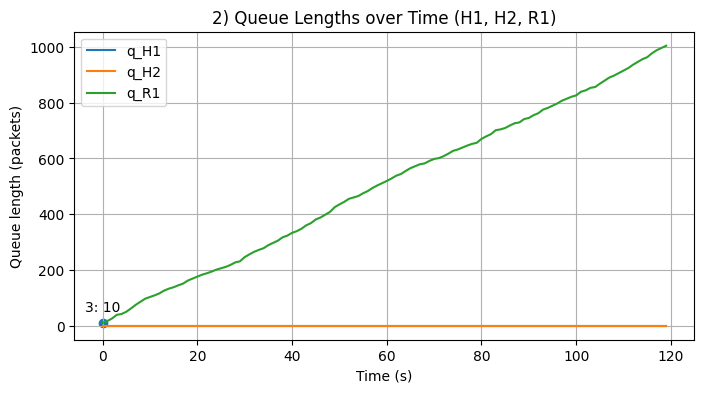

In [18]:
# --- Plot 2: queue lengths ---
plt.figure(figsize=(8,4))
plt.plot(summary_df['time_s'], summary_df['q_H1'], label="q_H1")
plt.plot(summary_df['time_s'], summary_df['q_H2'], label="q_H2")
plt.plot(summary_df['time_s'], summary_df['q_R1'], label="q_R1")
plt.xlabel("Time (s)"); plt.ylabel("Queue length (packets)")
plt.title("2) Queue Lengths over Time (H1, H2, R1)")
for i, series in enumerate(['q_H1','q_H2','q_R1'], start=1):
    arr = summary_df[series].values
    nz = np.nonzero(arr)[0]
    if nz.size > 0:
        idx = nz[0]; x = summary_df.loc[idx,'time_s']; y = arr[idx]
        plt.scatter([x],[y])
        plt.annotate(f"{i}: {int(y)}", (x,y), textcoords="offset points", xytext=(0,8), ha='center')
plt.legend(); plt.grid(True); plt.show()

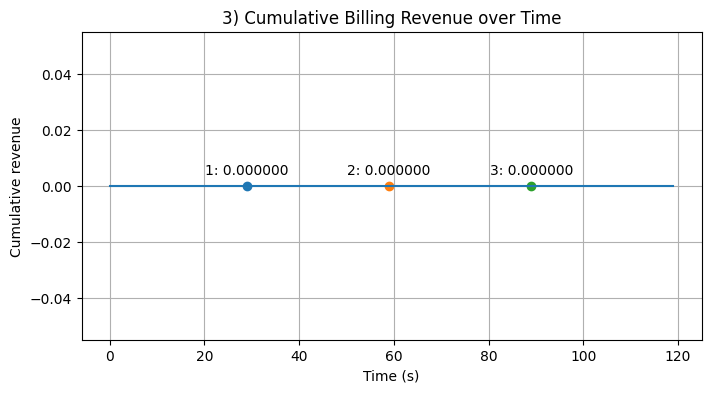

In [19]:
# --- Plot 3: cumulative billing revenue ---
plt.figure(figsize=(8,4))
plt.plot(summary_df['time_s'], summary_df['revenue_cum'])
plt.xlabel("Time (s)"); plt.ylabel("Cumulative revenue")
plt.title("3) Cumulative Billing Revenue over Time")
quantiles = [0.25, 0.5, 0.75]
for i, q in enumerate(quantiles, start=1):
    idx = int(q*(len(summary_df)-1)) if len(summary_df) > 1 else 0
    x = summary_df.loc[idx,'time_s']; y = summary_df.loc[idx,'revenue_cum']
    plt.scatter([x],[y])
    plt.annotate(f"{i}: {y:.6f}", (x,y), textcoords="offset points", xytext=(0,8), ha='center')
plt.grid(True); plt.show()

In [20]:
# --- Save outputs ---
summary_df.to_csv("simulation_summary.csv", index=False)
billing_records.to_csv("billing_records.csv", index=False)

print("Simulation complete.")
print(f"Packets generated: H1={len(H1.sent_packets)}, H2={len(H2.sent_packets)}")
print(f"Packets delivered: H1_received={len(H1.received_packets)}, H2_received={len(H2.received_packets)}")
print(f"Total revenue: {sum(rec['charge'] for rec in sim.billing.records):.6f}")
print("CSV files written: simulation_summary.csv, billing_records.csv")

Simulation complete.
Packets generated: H1=627, H2=377
Packets delivered: H1_received=0, H2_received=0
Total revenue: 0.000000
CSV files written: simulation_summary.csv, billing_records.csv


#b) Objects and Classes

An object is a collection of data and associated behaviors. In telecommunication systems, objects can represent network nodes, packets, user sessions, protocol handlers, or billing components. Each object encapsulates state (attributes) and operations (behaviors).

A class is a blueprint for creating objects. It defines the attributes and behaviors that all objects of that type share. For example, a RouterNode class might define attributes such as nodeID, status, and routingTable, and behaviors such as sendPacket() or receivePacket(). Individual router instances are objects that follow this blueprint.

## Differentiating Objects and Classes

Objects are specific instances; classes are templates. Just as multiple routers exist in a network, each router object has its own state, but all conform to the same class definition. Similarly, packets, sessions, or user accounts are individual objects modeled from their respective classes.

## Relationships Between Classes

Classes often interact. In a telecom network, a Packet object may be associated with a RouterNode object, or a Transaction object with a BillingEngine. These associations can be represented in a class diagram, a common feature of Unified Modeling Language (UML). UML diagrams visually show classes, their attributes, behaviors, and the relationships between them.

## Multiplicity (Cardinality) in Telecom Systems

Associations often have multiplicity, indicating how many objects of one class can relate to another. For example:

- One RouterNode can process many Packet objects.
- Each Packet travels through exactly one RouterNode at a given time.

Multiplicity ensures clarity in system design, specifying limits on associations, which is crucial for modeling network load, session management, or billing transactions.

## Usefulness of UML

Even if formal UML diagrams are not strictly maintained, the principles are valuable for:

- Communicating designs among engineers and managers.
- Documenting decisions for future reference.
- Modeling complex telecom systems iteratively.

UML is flexible; diagrams can be as simple or as detailed as needed. For instance, quick sketches can indicate associations between objects, while formal diagrams can specify multiplicity, cardinality, and optional constraints.


###Example 2 : Telecom OOP Class–Object Demonstration

This Python script demonstrates object-oriented principles in a telecom context using UML semantics. Packet instances represent data units, each associated with exactly one RouterNode at a time (1-to-1 multiplicity). RouterNode objects act as templates, holding queues of packets (1-to-many multiplicity) and forwarding them based on routing tables. A BillingEngine calculates charges per packet. The simulation creates routers, packets, defines forwarding rules, moves packets between routers, and records billing. It illustrates encapsulation, multiplicity, associations, and object interactions in a simple, traceable network system.


In [21]:
# ============================================================
# Telecom Object–Class Demonstration (OOP with UML semantics)
#  classes, objects, multiplicity, relations
# ============================================================

from dataclasses import dataclass
from typing import List, Dict, Optional
import itertools
import time

# ----------------------------
# Packet Class (many instances)
# ----------------------------

@dataclass
class Packet:
    pkt_id: int
    src: str
    dst: str
    size_bytes: int
    timestamp: float

    # Each packet is associated with exactly one router at a time (multiplicity 1..1)
    current_router: Optional[str] = None

    def set_router(self, router_id):
        """Associate packet with exactly one router (1-to-1 at a time)."""
        self.current_router = router_id


# ----------------------------------
# RouterNode Class (class → template)
# ----------------------------------

class RouterNode:
    _serial = itertools.count(1)

    def __init__(self, node_id: str):
        self.node_id = node_id
        self.routing_table: Dict[str, str] = {}
        self.queue: List[Packet] = []     # multiplicity: RouterNode 1 → * Packets

    # ----------------
    # Behaviors/Methods
    # ----------------
    def receive_packet(self, pkt: Packet):
        pkt.set_router(self.node_id)
        self.queue.append(pkt)

    def send_packet(self, dst_router: "RouterNode"):
        if not self.queue:
            return None
        pkt = self.queue.pop(0)
        dst_router.receive_packet(pkt)
        return pkt

    def set_route(self, dst, next_hop):
        self.routing_table[dst] = next_hop


# -------------------------------------
# BillingEngine (associated with packets)
# -------------------------------------

class BillingEngine:
    def __init__(self, rate_per_mb=0.02):
        self.rate_per_mb = rate_per_mb
        self.records = []

    def bill(self, pkt: Packet):
        charge = pkt.size_bytes / (1024 * 1024) * self.rate_per_mb
        self.records.append({
            "packet": pkt.pkt_id,
            "src": pkt.src,
            "dst": pkt.dst,
            "router": pkt.current_router,
            "charge": charge,
            "timestamp": pkt.timestamp
        })


# --------------------------
# UML-Style System Simulation
# --------------------------

# Create class instances (objects)
R1 = RouterNode("R1")
R2 = RouterNode("R2")

billing = BillingEngine()

# Define class-level relationships (forwarding rules)
R1.set_route(dst="H2", next_hop="R2")
R2.set_route(dst="H1", next_hop="R1")

# Create Packet objects (instances)
pkts = [
    Packet(pkt_id=1, src="H1", dst="H2", size_bytes=1200, timestamp=time.time()),
    Packet(pkt_id=2, src="H2", dst="H1", size_bytes=1400, timestamp=time.time()),
]

# Multiplicity demonstration
# R1 (1 router) → many packets
for p in pkts:
    R1.receive_packet(p)

# Routing demonstration (class interactions)
sent1 = R1.send_packet(R2)
sent2 = R1.send_packet(R2)

# Billing each packet at router R2
for p in R2.queue:
    billing.bill(p)

# Summary output
billing.records


[{'packet': 1,
  'src': 'H1',
  'dst': 'H2',
  'router': 'R2',
  'charge': 2.288818359375e-05,
  'timestamp': 1763434385.624221},
 {'packet': 2,
  'src': 'H2',
  'dst': 'H1',
  'router': 'R2',
  'charge': 2.6702880859375e-05,
  'timestamp': 1763434385.6242297}]

#c) Specifying Attributes and Behaviors

In object-oriented design, objects are instances of classes, each with its own data and behaviors. Attributes represent the state or properties of an object, while behaviors (methods) define actions that the object can perform.

## Attributes (Data) in Telecom Context

Attributes describe the characteristics of an object. For example:

- A RouterNode might have nodeID, status, routingTable.
- A Packet object could have source, destination, size, and priority.
- A UserSession object might include sessionID, userID, startTime, and duration.

Attributes can have primitive types (integer, string, boolean) or complex types (lists, dictionaries, or other objects). Associations between objects can also be treated as attributes; for example, a Packet might reference the RouterNode it is currently queued in. Each instance of a class can hold different data values for its attributes, even though all instances share the same attribute definitions.

## Behaviors (Methods) in Telecom Context

Behaviors are the actions that an object can perform. They are implemented as methods, which can access the object’s data and interact with other objects. For example:

- RouterNode.forward_packet(packet) moves a packet from one node to another.
- UserSession.authenticate() validates a user’s credentials.
- BillingEngine.calculate_charge(transaction) computes billing information for a completed session.

Methods may accept parameters (objects or values) and return results. For instance, forwarding a packet requires specifying the target node as a parameter. Methods can also update the state of multiple objects, such as removing a packet from a queue and updating a routing table.

## Summary of Interaction

By specifying attributes and behaviors, we define how objects store state and interact. In telecom systems, this enables modeling of real-world components like routers, packets, sessions, and billing engines. Each object instance may behave differently depending on its current state, allowing the system to reflect dynamic network conditions or user activity.


###Example 3 : Telecom OOP: Attributes and Behaviors
This Python code demonstrates object-oriented design for a telecom system by defining classes with attributes and behaviors. Packet objects store data like source, destination, size, and current router, with methods for setting the router and computing size in MB. RouterNode objects maintain queues and routing tables, with methods to receive and forward packets. UserSession tracks authentication and duration. BillingEngine computes charges per packet. The example simulates packet transfer between routers, billing, and user session authentication, illustrating OOP principles of encapsulation, state, and method-driven interactions.


In [22]:
# ============================================================
# Telecom OOP: Attributes and Behaviors
# ============================================================

from dataclasses import dataclass, field
from typing import List, Dict, Optional
import time
import itertools

# ----------------------------
# Packet Class
# ----------------------------
@dataclass
class Packet:
    pkt_id: int                 # attribute: unique identifier
    src: str                    # attribute: source node
    dst: str                    # attribute: destination node
    size_bytes: int             # attribute: packet size
    priority: int = 0           # attribute: priority (optional)
    timestamp: float = field(default_factory=time.time)
    current_router: Optional[str] = None   # attribute: current location

    # ----------------------------
    # Behavior: set current router
    # ----------------------------
    def set_router(self, router_id: str):
        self.current_router = router_id

    # ----------------------------
    # Behavior: compute size in MB
    # ----------------------------
    def size_mb(self):
        return self.size_bytes / (1024 * 1024)


# ----------------------------
# RouterNode Class
# ----------------------------
class RouterNode:
    _serial = itertools.count(1)

    def __init__(self, node_id: str, status: str = "active"):
        # Attributes (state)
        self.node_id = node_id
        self.status = status
        self.routing_table: Dict[str, str] = {}      # dst -> next_hop
        self.queue: List[Packet] = []               # packets queued for processing

    # ----------------------------
    # Behavior: receive a packet
    # ----------------------------
    def receive_packet(self, pkt: Packet):
        pkt.set_router(self.node_id)
        self.queue.append(pkt)

    # ----------------------------
    # Behavior: forward a packet to next hop
    # ----------------------------
    def forward_packet(self, dst_router: "RouterNode"):
        if not self.queue:
            return None
        pkt = self.queue.pop(0)  # remove from queue
        dst_router.receive_packet(pkt)  # send to next router
        return pkt

    # ----------------------------
    # Behavior: update routing table
    # ----------------------------
    def set_route(self, dst: str, next_hop: str):
        self.routing_table[dst] = next_hop


# ----------------------------
# UserSession Class
# ----------------------------
@dataclass
class UserSession:
    session_id: int
    user_id: str
    start_time: float = field(default_factory=time.time)
    duration_s: Optional[float] = None
    authenticated: bool = False

    # ----------------------------
    # Behavior: authenticate user
    # ----------------------------
    def authenticate(self, password: str):
        # simple demo: password == user_id reversed
        if password == self.user_id[::-1]:
            self.authenticated = True
        return self.authenticated

    # ----------------------------
    # Behavior: end session
    # ----------------------------
    def end_session(self):
        self.duration_s = time.time() - self.start_time
        return self.duration_s


# ----------------------------
# BillingEngine Class
# ----------------------------
class BillingEngine:
    def __init__(self, rate_per_mb: float = 0.01):
        # Attributes
        self.rate_per_mb = rate_per_mb
        self.records: List[Dict] = []

    # Behavior: calculate billing for a packet
    def calculate_charge(self, pkt: Packet):
        charge = pkt.size_mb() * self.rate_per_mb
        self.records.append({
            "packet_id": pkt.pkt_id,
            "src": pkt.src,
            "dst": pkt.dst,
            "router": pkt.current_router,
            "charge": charge,
            "timestamp": pkt.timestamp
        })
        return charge


# ----------------------------
# Example Interaction
# ----------------------------

# Create objects (instances)
R1 = RouterNode("R1")
R2 = RouterNode("R2")
billing = BillingEngine()
session1 = UserSession(session_id=1, user_id="alice")

# Packet creation (attributes)
pkt1 = Packet(pkt_id=101, src="H1", dst="H2", size_bytes=1500, priority=1)
pkt2 = Packet(pkt_id=102, src="H2", dst="H1", size_bytes=2000, priority=0)

# Router interactions (behaviors)
R1.receive_packet(pkt1)
R1.receive_packet(pkt2)

# Forward packets
forwarded_pkt1 = R1.forward_packet(R2)
forwarded_pkt2 = R1.forward_packet(R2)

# Billing computation (behavior)
billing.calculate_charge(forwarded_pkt1)
billing.calculate_charge(forwarded_pkt2)

# User session interaction (behaviors)
auth_success = session1.authenticate("ecila")  # reversed user_id
session_duration = session1.end_session()

# ----------------------------
# Summary output
# ----------------------------
print("Router R2 queue:", [pkt.pkt_id for pkt in R2.queue])
print("Billing records:", billing.records)
print(f"User session authenticated: {auth_success}, duration: {session_duration:.2f}s")


Router R2 queue: [101, 102]
Billing records: [{'packet_id': 101, 'src': 'H1', 'dst': 'H2', 'router': 'R2', 'charge': 1.430511474609375e-05, 'timestamp': 1763434385.6562755}, {'packet_id': 102, 'src': 'H2', 'dst': 'H1', 'router': 'R2', 'charge': 1.9073486328125e-05, 'timestamp': 1763434385.6563172}]
User session authenticated: True, duration: 0.00s


#d) Hiding Details and Creating the Public Interface

A key goal in object-oriented design is defining the public interface of an object—the attributes and methods that other objects can access. The internal workings of the object should generally remain hidden, a principle known as information hiding. In telecommunications, this allows network components or software modules to interact without knowing implementation details.

## Example in Telecom

Consider a RouterNode object. Its public interface might include methods like forward_packet(packet) and update_routing_table(). Other objects, such as Packet or NetworkMonitor, can call these methods without knowing how packets are routed internally, whether the node uses OSPF or BGP, or how the routing table is stored.

## Encapsulation vs Information Hiding

Encapsulation refers to grouping data and methods into a single object (the “capsule”). Information hiding means restricting access to the internal data and logic. While Python does not enforce strict hiding, the concept is important at the design level: we treat private details as internal and expose only what is needed through the public interface.

## Abstraction

Abstraction involves presenting only the relevant details for a given task. In telecom, a network administrator interacts with interfaces like RouterNode.status or RouterNode.forward_packet(), without needing to know how the routing algorithm works internally. Abstraction allows models to focus on what matters for each interacting object or subsystem.

## Design Principles for Interfaces

- Methods and attributes should have clear, meaningful names: nouns for objects/attributes, verbs for behaviors.
- Keep the interface stable, as changing it affects all objects that rely on it.
- Internal implementation can change freely to improve efficiency, security, or scalability, as long as the public interface remains consistent.
- Design interfaces for ease of use by other objects, not for implementation convenience.

## Telecom Relevance

By carefully defining public interfaces and hiding internal details, telecom software components—like routers, session managers, billing engines, or IoT gateways—can interact modularly, enabling maintainable, scalable, and robust networked systems.


###Example 4 : Telecom OOD: Encapsulation and Public Interface

This code demonstrates object-oriented design emphasizing encapsulation and public interfaces. Packet hides its _current_router attribute, exposing only set_router and get_router methods. RouterNode encapsulates its queue and routing table, providing public methods like receive_packet, forward_packet, update_routing_table, and queue_length, while internal logic such as _select_next_hop remains hidden. BillingEngine stores charges privately, exposing bill_packet and get_records for safe access. Example interactions show packets moving between routers, billing computation, and state inspection, illustrating secure, maintainable telecom system design.


In [23]:
# ============================================================
# Telecom OOD: Hiding Details and Creating Public Interface
# ============================================================

from dataclasses import dataclass, field
from typing import List, Dict, Optional
import time
import itertools

# ----------------------------
# Packet Class (Encapsulated)
# ----------------------------
@dataclass
class Packet:
    pkt_id: int
    src: str
    dst: str
    size_bytes: int
    timestamp: float = field(default_factory=time.time)

    # Internal attribute: current router (hidden)
    _current_router: Optional[str] = field(default=None, repr=False)

    # ----------------------------
    # Public Interface: set and get current router
    # ----------------------------
    def set_router(self, router_id: str):
        self._current_router = router_id

    def get_router(self):
        return self._current_router

    def size_mb(self):
        return self.size_bytes / (1024*1024)


# ----------------------------
# RouterNode Class (Encapsulation & Interface)
# ----------------------------
class RouterNode:
    _serial = itertools.count(1)

    def __init__(self, node_id: str):
        # Public attribute
        self.node_id = node_id
        # Private/internal attributes
        self._queue: List[Packet] = []  # hidden queue implementation
        self._routing_table: Dict[str, str] = {}  # hidden

    # ----------------------------
    # Public interface: receive a packet
    # ----------------------------
    def forward_packet(self, dst_router: "RouterNode"):
        """Forward one packet to another router"""
        if not self._queue:
            return None
        pkt = self._queue.pop(0)  # queue details hidden
        pkt.set_router(dst_router.node_id)
        dst_router.receive_packet(pkt)
        return pkt

    # ----------------------------
    # Public interface: add packet to queue
    # ----------------------------
    def receive_packet(self, pkt: Packet):
        self._queue.append(pkt)

    # ----------------------------
    # Public interface: routing table manipulation
    # ----------------------------
    def update_routing_table(self, dst: str, next_hop: str):
        self._routing_table[dst] = next_hop

    # ----------------------------
    # Public interface: inspect queue length
    # ----------------------------
    def queue_length(self):
        return len(self._queue)

    # ----------------------------
    # Internal method (hidden)
    # ----------------------------
    def _select_next_hop(self, dst: str) -> Optional[str]:
        """Private method: selects next hop (implementation hidden)"""
        return self._routing_table.get(dst, None)


# ----------------------------
# BillingEngine Class (Encapsulated)
# ----------------------------
class BillingEngine:
    def __init__(self, rate_per_mb: float = 0.01):
        self.rate_per_mb = rate_per_mb
        self._records: List[Dict] = []  # hidden storage

    # ----------------------------
    # Public interface
    # ----------------------------
    def bill_packet(self, pkt: Packet):
        charge = pkt.size_mb() * self.rate_per_mb
        self._records.append({
            "packet": pkt.pkt_id,
            "src": pkt.src,
            "dst": pkt.dst,
            "router": pkt.get_router(),
            "charge": charge,
            "timestamp": pkt.timestamp
        })
        return charge

    def get_records(self):
        """Public method to access billing information"""
        return self._records.copy()  # return copy to avoid direct manipulation


# ----------------------------
# Example Interaction
# ----------------------------

# Create routers and billing engine
R1 = RouterNode("R1")
R2 = RouterNode("R2")
billing = BillingEngine()

# Create packets
pkt1 = Packet(pkt_id=201, src="H1", dst="H2", size_bytes=1500)
pkt2 = Packet(pkt_id=202, src="H2", dst="H1", size_bytes=2500)

# Queue packets in R1
R1.receive_packet(pkt1)
R1.receive_packet(pkt2)

# Forward packets to R2 using public interface
R1.forward_packet(R2)
R1.forward_packet(R2)

# Bill packets at R2
for pkt in [pkt1, pkt2]:
    billing.bill_packet(pkt)

# Inspect state using public interfaces
print("R2 queue length:", R2.queue_length())
print("Billing records:", billing.get_records())


R2 queue length: 2
Billing records: [{'packet': 201, 'src': 'H1', 'dst': 'H2', 'router': 'R2', 'charge': 1.430511474609375e-05, 'timestamp': 1763434385.6774187}, {'packet': 202, 'src': 'H2', 'dst': 'H1', 'router': 'R2', 'charge': 2.384185791015625e-05, 'timestamp': 1763434385.6774626}]


#e) Composition

Composition is an object-oriented principle used to build complex objects by combining simpler ones. It is especially useful for modeling systems with hierarchical relationships or “part-of” structures.

## Definition

**Composition:** A relationship where one object is made up of other objects. The composite object controls the lifecycle of its components.

**Aggregation:** A weaker form of composition where related objects can exist independently of the composite.

## Telecom Context Examples

- A Network object may be composed of multiple RouterNode and SwitchNode objects.
- A RouterNode could be composed of Interface objects representing physical or virtual ports.
- A TelecomSession may aggregate Packet objects, since packets exist independently and can be created or destroyed separately from the session.

## Key Concepts

- Composition provides levels of abstraction: higher-level objects expose a public interface, while components encapsulate internal details.
- The lifetime of components is controlled by the composite in composition; in aggregation, components may outlive or exist independently of the composite.
- UML notation: solid diamond indicates composition; hollow diamond indicates aggregation.

## Illustrative Example: Telecom Network

- A Network object contains multiple RouterNode objects (composition).
- Each RouterNode contains multiple Interface objects (composition).
- Packets flowing through the network are aggregated with sessions (TelecomSession aggregates Packet).

## Practical Implications

Composition allows telecom engineers to model complex systems naturally, reflecting real-world hierarchical structures: nodes in a network, interfaces in a router, or billing components in a session. Aggregation is useful for objects that exist independently but interact with other components. Understanding these relationships improves modularity, maintainability, and clarity in design.


###Example 5 : Telecom OOD: Composition and Aggregation

This code illustrates composition and aggregation in telecom object-oriented design. RouterNode composes Interface objects, controlling their lifecycle and exposing interface status. TelecomSession aggregates Packet objects, which can exist independently but are grouped for session-level operations. Routers receive and forward packets using public methods, while sessions track total transmitted data. The example demonstrates routers with multiple interfaces, packets aggregated into a session, and safe interaction between components, emphasizing the distinction between strong ownership (composition) and loose association (aggregation) in telecom system modeling.


In [24]:
# ============================================================
# Telecom OOD: Composition and Aggregation
# ============================================================

from dataclasses import dataclass, field
from typing import List, Dict, Optional
import time

# ----------------------------
# Packet class (aggregated)
# ----------------------------
@dataclass
class Packet:
    pkt_id: int
    src: str
    dst: str
    size_bytes: int
    timestamp: float = field(default_factory=time.time)

    # Aggregated into sessions (can exist independently)
    def size_mb(self):
        return self.size_bytes / (1024*1024)


# ----------------------------
# Interface class (part of RouterNode, composition)
# ----------------------------
@dataclass
class Interface:
    if_name: str
    bandwidth_bps: float
    status: str = "up"

    def is_active(self):
        return self.status == "up"


# ----------------------------
# RouterNode class (composition of Interfaces)
# ----------------------------
class RouterNode:
    def __init__(self, node_id: str):
        self.node_id = node_id
        self._interfaces: List[Interface] = []  # composition: Router controls Interface lifecycle
        self._queue: List[Packet] = []

    # ----------------------------
    # Composition: add interface
    # ----------------------------
    def add_interface(self, if_obj: Interface):
        self._interfaces.append(if_obj)

    # ----------------------------
    # Public interface
    # ----------------------------
    def receive_packet(self, pkt: Packet):
        self._queue.append(pkt)

    def forward_packet(self, dst_node: "RouterNode"):
        if not self._queue:
            return None
        pkt = self._queue.pop(0)
        dst_node.receive_packet(pkt)
        return pkt

    def interfaces_status(self):
        return {iface.if_name: iface.status for iface in self._interfaces}


# ----------------------------
# TelecomSession class (aggregates Packets)
# ----------------------------
class TelecomSession:
    def __init__(self, session_id: int, user_id: str):
        self.session_id = session_id
        self.user_id = user_id
        self.packets: List[Packet] = []  # aggregation: packets may exist independently

    # ----------------------------
    # Add packet to session (aggregated)
    # ----------------------------
    def add_packet(self, pkt: Packet):
        self.packets.append(pkt)

    # ----------------------------
    # Compute total data transmitted
    # ----------------------------
    def total_data_mb(self):
        return sum(pkt.size_mb() for pkt in self.packets)


# ----------------------------
# Example Simulation
# ----------------------------

# Create router with interfaces (composition)
R1 = RouterNode("R1")
R1.add_interface(Interface("eth0", bandwidth_bps=1e7))
R1.add_interface(Interface("eth1", bandwidth_bps=5e6))

R2 = RouterNode("R2")
R2.add_interface(Interface("eth0", bandwidth_bps=1e7))

# Create packets (aggregated into session)
pkt1 = Packet(pkt_id=301, src="H1", dst="H2", size_bytes=1500)
pkt2 = Packet(pkt_id=302, src="H1", dst="H2", size_bytes=2000)

session = TelecomSession(session_id=1, user_id="alice")
session.add_packet(pkt1)
session.add_packet(pkt2)

# Queue packets in router and forward (composition interaction)
R1.receive_packet(pkt1)
R1.receive_packet(pkt2)
R1.forward_packet(R2)
R1.forward_packet(R2)

# Inspect state
print("Router R1 interfaces:", R1.interfaces_status())
print("Router R2 queue length:", len(R2._queue))
print(f"Session {session.session_id} total data transmitted: {session.total_data_mb():.4f} MB")


Router R1 interfaces: {'eth0': 'up', 'eth1': 'up'}
Router R2 queue length: 2
Session 1 total data transmitted: 0.0033 MB


#f) Inheritance

Inheritance is an object-oriented principle that allows a class (child/subclass) to acquire attributes and methods from another class (parent/superclass). It models “is-a” relationships, enabling code reuse, abstraction, and polymorphism.

## Definition

**Inheritance:** Mechanism by which one class (child) derives properties and behaviors from another class (parent).

**Abstract class:** A class that defines a template with required methods but does not provide full implementation.

**Polymorphism:** The ability to use a single interface to represent objects of different types.

## Telecom Context Examples

- A RouterNode superclass might define attributes like nodeID and status, and methods like forward_packet().
- A CoreRouter subclass inherits these attributes and methods but adds optimize_routing() or aggregate_traffic() methods.
- An EdgeRouter subclass might override forward_packet() to apply firewall rules or QoS policies.

## Key Concepts

- Inheritance supports abstraction, allowing systems to treat objects generically while the specific subclass handles implementation details. For example, a NetworkManager object can call forward_packet() on any RouterNode without knowing if it is a core or edge router.
- Polymorphism in telecom systems allows methods to behave differently based on the object type, e.g., forwarding a packet differently on CoreRouter versus EdgeRouter. Python achieves this using duck typing: any object with a required method can be used interchangeably, regardless of its class hierarchy.
- **Multiple Inheritance:** A subclass can inherit from more than one parent class, combining behaviors. For example, a ScannerFaxDevice could inherit from both Scanner and Faxer classes. Multiple inheritance can be complex if parent classes have overlapping methods; careful design is required.

## Practical Implications in Telecom

- Inheritance enables modular network design: NetworkNode → RouterNode → EdgeRouter.
- Abstract classes define common interfaces for network components (forward_packet()), ensuring that new implementations comply with expected behaviors.
- Polymorphism allows flexible integration of new devices, protocols, or AI-driven modules without changing existing system logic.
- Multiple inheritance should be used cautiously, only when it naturally models “is-a” relationships; otherwise, composition or aggregation may be more appropriate.

## Summary

Inheritance is a powerful mechanism for structuring telecom and information systems, promoting reusability and abstraction. It should model real “is-a” relationships rather than be used solely for code sharing. Properly applied, it allows flexible, maintainable, and scalable network software.


###Example 6 : Telecom OOD: Inheritance and Polymorphism

This code demonstrates inheritance and polymorphism in telecom object-oriented design. NetworkNode is an abstract base class defining a common interface for all network nodes. RouterNode implements basic forwarding, while CoreRouter and EdgeRouter extend it, overriding forward_packet to add specialized behaviors: optimized routing for core routers and QoS/firewall rules for edge routers. Packets are forwarded through a hierarchy of routers, showcasing dynamic method dispatch. This design models real-world telecom networks with reusable, extensible node types supporting different operational policies.


In [25]:
from abc import ABC, abstractmethod
from typing import List
from dataclasses import dataclass, field
import time

# ----------------------------
# Packet class
# ----------------------------
@dataclass
class Packet:
    pkt_id: int
    src: str
    dst: str
    size_bytes: int
    timestamp: float = field(default_factory=time.time)

    def size_mb(self):
        return self.size_bytes / (1024*1024)


# ----------------------------
# Abstract base class: NetworkNode
# ----------------------------
class NetworkNode(ABC):
    def __init__(self, node_id: str):
        self.node_id = node_id
        self._queue: List[Packet] = []

    def receive_packet(self, pkt: Packet):
        self._queue.append(pkt)

    @abstractmethod
    def forward_packet(self, dst_node: "NetworkNode"):
        """Abstract method: must be implemented in subclasses"""
        pass

    def queue_length(self):
        return len(self._queue)


# ----------------------------
# RouterNode subclass
# ----------------------------
class RouterNode(NetworkNode):
    def __init__(self, node_id: str):
        super().__init__(node_id)
        self._routing_table = {}

    def forward_packet(self, dst_node: NetworkNode):
        """Simple FIFO forwarding"""
        if self._queue:
            pkt = self._queue.pop(0)
            dst_node.receive_packet(pkt)
            return pkt
        return None

    def update_routing_table(self, dst: str, next_hop: str):
        self._routing_table[dst] = next_hop


# ----------------------------
# CoreRouter subclass (inherits RouterNode)
# ----------------------------
class CoreRouter(RouterNode):
    def optimize_routing(self):
        """Example additional behavior"""
        print(f"[CoreRouter {self.node_id}] Optimizing routing table...")
        # placeholder for optimization algorithm

    def forward_packet(self, dst_node: NetworkNode):
        """Override to simulate optimized forwarding"""
        pkt = super().forward_packet(dst_node)
        if pkt:
            print(f"[CoreRouter {self.node_id}] Forwarded packet {pkt.pkt_id} with optimized path")
        return pkt


# ----------------------------
# EdgeRouter subclass (inherits RouterNode)
# ----------------------------
class EdgeRouter(RouterNode):
    def forward_packet(self, dst_node: NetworkNode):
        """Override to apply QoS/firewall rules"""
        if self._queue:
            pkt = self._queue.pop(0)
            # Example: drop packets larger than 2MB
            if pkt.size_mb() > 2:
                print(f"[EdgeRouter {self.node_id}] Dropped packet {pkt.pkt_id} due to size limit")
                return None
            dst_node.receive_packet(pkt)
            print(f"[EdgeRouter {self.node_id}] Forwarded packet {pkt.pkt_id} with QoS rules")
            return pkt
        return None


# ----------------------------
# Example Simulation
# ----------------------------
# Create nodes
core = CoreRouter("Core1")
edge = EdgeRouter("Edge1")
host_dst = RouterNode("H2")  # could also be a HostNode in future

# Create packets
pkt1 = Packet(pkt_id=401, src="H1", dst="H2", size_bytes=1_000_000)
pkt2 = Packet(pkt_id=402, src="H1", dst="H2", size_bytes=3_000_000)

# Queue packets in edge router
edge.receive_packet(pkt1)
edge.receive_packet(pkt2)

# Forward through edge router -> core router -> destination
edge.forward_packet(core)
edge.forward_packet(core)

core.forward_packet(host_dst)
core.forward_packet(host_dst)

# Inspect queue lengths
print(f"Host/Destination queue length: {host_dst.queue_length()}")


[EdgeRouter Edge1] Forwarded packet 401 with QoS rules
[EdgeRouter Edge1] Dropped packet 402 due to size limit
[CoreRouter Core1] Forwarded packet 401 with optimized path
Host/Destination queue length: 1


# Case Study: Object-Oriented Design for a Library Catalog

This case study demonstrates iterative object-oriented analysis and design (OOAD) using a library catalog system. The principles are transferable to telecom systems, such as managing network devices, subscriber services, or media streaming libraries.

## Step 1: Initial Analysis

**Domain objects identified from problem description:**

- **Book** → attributes: title, author, ISBN, subject, DDS_number
- **Catalog** → manages collections of books; provides search functionality

**Questions considered during analysis:**

- Should authors be objects or just attributes?
- Do physical storage details (shelves) matter?
- Are users actively tracked or only interface with the catalog?

**Decisions:**

- Authors are separate objects because one author may have multiple books.
- Shelf objects are unnecessary; DDS number suffices for locating books.
- Users are only part of the interface; no need to model them internally.

## Step 2: Basic Object Design

**Objects & attributes:**

- **Book:** title, ISBN, subject, contributors
- **Catalog:** collection (private), search_by_author(), search_by_title(), search_by_subject()

**Initial behavior modeling:**

- Books can have a preview() method or first_page attribute.
- Catalog performs search and locate operations.

## Step 3: Handling Multiple Media Types

Libraries store books, DVDs, CDs, magazines, each with different identifiers (ISBN, UPC) and organization schemes (DDS, title, genre, volume).

**Solution: Use inheritance**

- **Base class:** LibraryItem → attributes: title, contributors
- **Subclasses:** Book, DVD, CD, Magazine → specialized attributes and locate() methods
- Catalog can search generically across LibraryItem objects, then call locate() per item type.

## Step 4: Contributors & Polymorphism

**Problem:** Contributors (authors, artists, actors) have varying roles.

**Options:**

- Inheritance (Author, Actor, Artist subclasses) → leads to bulky design.
- Composition → create Contributor class and store contributor_type as attribute.

**Design improvement:**

- Each LibraryItem has a list of Contribution objects linking a Contributor to the LibraryItem with role info.
- Polymorphic method get_contributors() ensures the catalog interface works regardless of media type.

## Step 5: Refactoring Principles

Refactor design to simplify relationships and improve maintainability:

- Remove unnecessary inheritance when there is no specialization.
- Use composition for flexible relationships (e.g., Contributor → LibraryItem).
- Abstract public interfaces from internal complexity (locate(), get_contributors()).

## Key Lessons for Telecom/Information Systems

- **Start from analysis:** Identify core objects, attributes, and behaviors.
- **Use abstraction:** Focus on what the system needs to know, not all real-world details.
- **Inheritance vs. composition:**
  - **Inheritance:** for clear “is-a” relationships (e.g., Router → EdgeRouter).
  - **Composition:** for flexible associations (e.g., NetworkService composed of Bandwidth and QoS objects).
- **Polymorphism:** Allows a single interface to handle different subclasses (e.g., locate() for Book, DVD, or CD).
- **Refactor iteratively:** Simplify design for maintainability and extensibility.
- **Sequence diagrams:** Useful to model interactions (e.g., catalog searches, device communications, API calls).


####Static

In [26]:
from dataclasses import dataclass, field
from typing import List, Dict

# ----------------------------
# Contributor (composition example)
# ----------------------------
@dataclass
class Contributor:
    name: str
    contributor_type: str  # e.g., "Author", "Actor", "Artist"


# ----------------------------
# Contribution links Contributor to LibraryItem (role info)
# ----------------------------
@dataclass
class Contribution:
    contributor: Contributor
    role: str  # e.g., "Author", "Director", "Singer"


# ----------------------------
# Base class: LibraryItem (abstraction)
# ----------------------------
class LibraryItem:
    def __init__(self, title: str, contributors: List[Contribution]):
        self.title = title
        self._contributors = contributors  # encapsulated

    # Polymorphic interface
    def get_contributors(self):
        return [(c.contributor.name, c.role) for c in self._contributors]

    def locate(self):
        """Abstract method: overridden by subclasses"""
        raise NotImplementedError("Subclasses must implement locate()")


# ----------------------------
# Subclasses for different media types
# ----------------------------
class Book(LibraryItem):
    def __init__(self, title: str, contributors: List[Contribution], ISBN: str, DDS_number: str):
        super().__init__(title, contributors)
        self.ISBN = ISBN
        self.DDS_number = DDS_number

    def locate(self):
        return f"DDS Shelf: {self.DDS_number}"


class DVD(LibraryItem):
    def __init__(self, title: str, contributors: List[Contribution], UPC: str, genre: str):
        super().__init__(title, contributors)
        self.UPC = UPC
        self.genre = genre

    def locate(self):
        return f"DVD Section: {self.genre}"


class Magazine(LibraryItem):
    def __init__(self, title: str, contributors: List[Contribution], volume: int):
        super().__init__(title, contributors)
        self.volume = volume

    def locate(self):
        return f"Magazine Rack, Volume: {self.volume}"


# ----------------------------
# Catalog class (composition + polymorphism)
# ----------------------------
class Catalog:
    def __init__(self):
        self._collection: List[LibraryItem] = []

    def add_item(self, item: LibraryItem):
        self._collection.append(item)

    # Polymorphic search
    def search_by_title(self, title: str) -> List[LibraryItem]:
        return [item for item in self._collection if title.lower() in item.title.lower()]

    def search_by_contributor(self, contributor_name: str) -> List[LibraryItem]:
        result = []
        for item in self._collection:
            for name, _ in item.get_contributors():
                if contributor_name.lower() in name.lower():
                    result.append(item)
        return result

    def locate_items(self, items: List[LibraryItem]):
        for item in items:
            print(f"{item.title} → {item.locate()}")


# ----------------------------
# Example usage
# ----------------------------
# Contributors
alice = Contributor("Alice Smith", "Author")
bob = Contributor("Bob Johnson", "Actor")

# Contributions
c1 = Contribution(alice, "Author")
c2 = Contribution(bob, "Lead Actor")

# Library items
book1 = Book("Python for Telecom", [c1], ISBN="123-456-789", DDS_number="QA76.73.P98")
dvd1 = DVD("Network Simulator Demo", [c2], UPC="987654321", genre="Education")
mag1 = Magazine("Telecom Today", [], volume=42)

# Catalog
catalog = Catalog()
catalog.add_item(book1)
catalog.add_item(dvd1)
catalog.add_item(mag1)

# Search examples
print("Search by title 'Python':")
results = catalog.search_by_title("Python")
catalog.locate_items(results)

print("\nSearch by contributor 'Bob':")
results2 = catalog.search_by_contributor("Bob")
catalog.locate_items(results2)


Search by title 'Python':
Python for Telecom → DDS Shelf: QA76.73.P98

Search by contributor 'Bob':
Network Simulator Demo → DVD Section: Education


##Interactive

In [27]:
from dataclasses import dataclass
from typing import List

# ----------------------------
# Contributor & Contribution
# ----------------------------
@dataclass
class Contributor:
    name: str
    contributor_type: str  # e.g., "Author", "Actor", "Artist"

@dataclass
class Contribution:
    contributor: Contributor
    role: str  # e.g., "Author", "Director", "Singer"

# ----------------------------
# Base LibraryItem
# ----------------------------
class LibraryItem:
    def __init__(self, title: str, contributors: List[Contribution]):
        self.title = title
        self._contributors = contributors

    def get_contributors(self):
        return [(c.contributor.name, c.role) for c in self._contributors]

    def locate(self):
        raise NotImplementedError("Subclasses must implement locate()")

# ----------------------------
# Subclasses
# ----------------------------
class Book(LibraryItem):
    def __init__(self, title, contributors, ISBN, DDS_number):
        super().__init__(title, contributors)
        self.ISBN = ISBN
        self.DDS_number = DDS_number
    def locate(self):
        return f"DDS Shelf: {self.DDS_number}"

class DVD(LibraryItem):
    def __init__(self, title, contributors, UPC, genre):
        super().__init__(title, contributors)
        self.UPC = UPC
        self.genre = genre
    def locate(self):
        return f"DVD Section: {self.genre}"

class Magazine(LibraryItem):
    def __init__(self, title, contributors, volume):
        super().__init__(title, contributors)
        self.volume = volume
    def locate(self):
        return f"Magazine Rack, Volume: {self.volume}"

# ----------------------------
# Catalog
# ----------------------------
class Catalog:
    def __init__(self):
        self._collection: List[LibraryItem] = []

    def add_item(self, item: LibraryItem):
        self._collection.append(item)

    def search_by_title(self, title: str):
        return [item for item in self._collection if title.lower() in item.title.lower()]

    def search_by_contributor(self, contributor_name: str):
        result = []
        for item in self._collection:
            for name, _ in item.get_contributors():
                if contributor_name.lower() in name.lower():
                    result.append(item)
        return result

    def locate_items(self, items: List[LibraryItem]):
        for item in items:
            print(f"{item.title} → {item.locate()}")

# ----------------------------
# Interactive CLI
# ----------------------------
catalog = Catalog()

print("=== Welcome to Interactive Library Catalog ===")

while True:
    print("\nOptions:\n1: Add Book\n2: Add DVD\n3: Add Magazine\n4: Search by Title\n5: Search by Contributor\n6: Exit")
    choice = input("Enter option number: ").strip()

    if choice == "1":
        title = input("Enter book title: ")
        ISBN = input("Enter ISBN: ")
        DDS_number = input("Enter DDS number: ")
        author_name = input("Enter author name: ")
        contributor = Contributor(author_name, "Author")
        contribution = Contribution(contributor, "Author")
        book = Book(title, [contribution], ISBN, DDS_number)
        catalog.add_item(book)
        print(f"Book '{title}' added.")

    elif choice == "2":
        title = input("Enter DVD title: ")
        genre = input("Enter genre: ")
        UPC = input("Enter UPC code: ")
        actor_name = input("Enter actor/director name: ")
        contributor = Contributor(actor_name, "Actor")
        contribution = Contribution(contributor, "Lead Actor")
        dvd = DVD(title, [contribution], UPC, genre)
        catalog.add_item(dvd)
        print(f"DVD '{title}' added.")

    elif choice == "3":
        title = input("Enter magazine title: ")
        volume = input("Enter volume number: ")
        magazine = Magazine(title, [], int(volume))
        catalog.add_item(magazine)
        print(f"Magazine '{title}' added.")

    elif choice == "4":
        title = input("Enter title to search: ")
        results = catalog.search_by_title(title)
        if results:
            print(f"Found {len(results)} item(s):")
            catalog.locate_items(results)
        else:
            print("No items found.")

    elif choice == "5":
        contributor_name = input("Enter contributor name to search: ")
        results = catalog.search_by_contributor(contributor_name)
        if results:
            print(f"Found {len(results)} item(s):")
            catalog.locate_items(results)
        else:
            print("No items found.")

    elif choice == "6":
        print("Exiting interactive catalog. Goodbye!")
        break

    else:
        print("Invalid option. Try again.")


=== Welcome to Interactive Library Catalog ===

Options:
1: Add Book
2: Add DVD
3: Add Magazine
4: Search by Title
5: Search by Contributor
6: Exit
Enter option number: 1
Enter book title: Seth Data Science
Enter ISBN: w234
Enter DDS number: 768i
Enter author name: Seth Kipsang
Book 'Seth Data Science' added.

Options:
1: Add Book
2: Add DVD
3: Add Magazine
4: Search by Title
5: Search by Contributor
6: Exit
Enter option number: 12
Invalid option. Try again.

Options:
1: Add Book
2: Add DVD
3: Add Magazine
4: Search by Title
5: Search by Contributor
6: Exit
Enter option number: 6
Exiting interactive catalog. Goodbye!
